# Submodule #4: Microbiome Community Analysis

# Learning Objectives:
- Perform microbiome community analysis using BLAST+ and Google BigQuery with the STRING database
- Create a fasta file
- Create a Google Cloud Storage Bucket
- Submit jobs directly to Google Life Sciences API

---
# Training Plan 


Submodule #0: Introduction - Concept Inventory and Workflow Overview

 
Submodule #1:  Metagenome Data Preparation and QC

 
Submodule #2: Microbiome Analysis


Submodule #3: Biomarker Discovery

 
<font color="green"> **Submodule #4: Microbiome Community Analysis** </font>

Submodule #5: Metagenomics Analysis of Microbiome Community and Biofilm Using NextFlow!


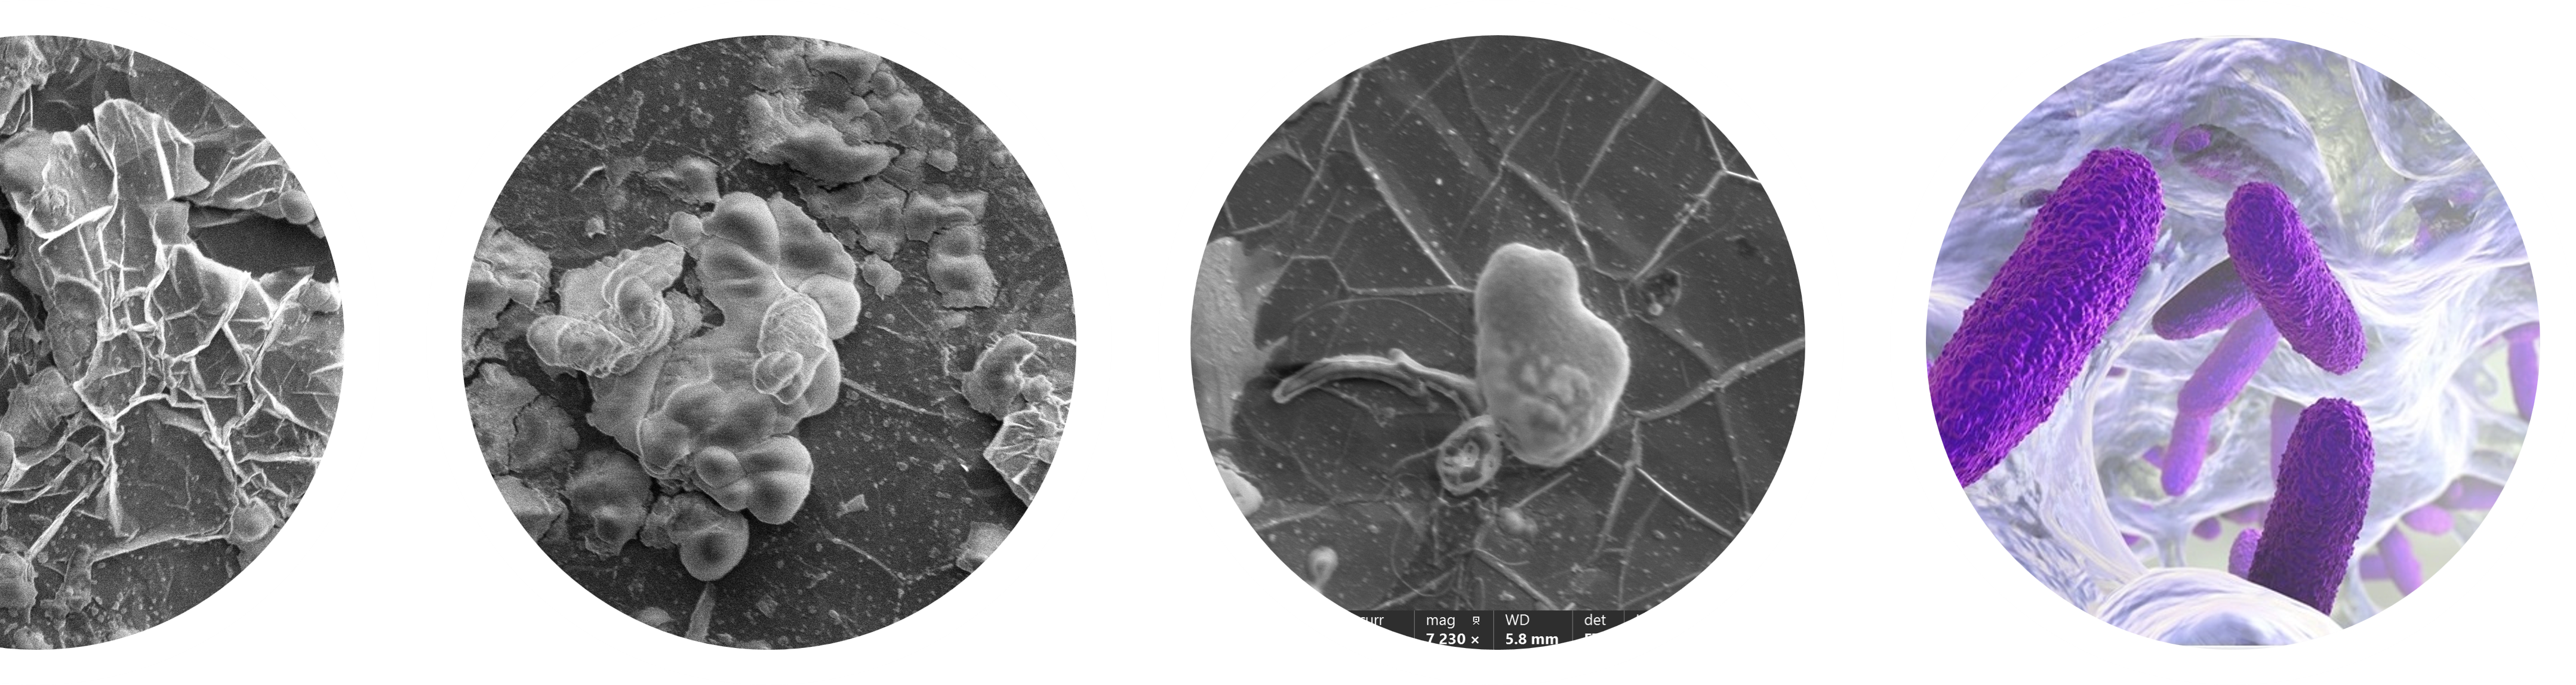

--------------------------------------------------------------

<div class="alert alert-block alert-info">
    <i class="fa fa-lightbulb-o" aria-hidden="true"></i>
    <b>Tip: </b> This version of the training module uses Docker. If you have any docker related issue, refer to our troubleshooting section within the README. 
</div>

## Step 5 - Microbial Community and Biofilm Analysis (Google BigQuery and BLAST+): 

The microbial community analysis relies on comparisons of predicted genes, proteins, and functions with existing previously annotated sequences. Functional profiling provides insights into what functions are carried out by a given microbial community and biofilm. Quorum sensing (QS) is one of the key indicators of a bacterial community's behavior. QS is the regulation of gene expression in response to fluctuations in cell-population density. QS bacteria produce and release chemical signaling molecules called autoinducers that increase in concentration as a function of cell density. The presence of QS signaling does not always guarantee biofilm formation, but this phenomenon has proven to be a reliable marker in several phenotype analyses of biofilms, such as those involved in cancer, dental health, medical devices, corrosion, and environmental biofilms.  Here we use the STRING Database and BLAST+ to search for biofilm signatures in our metagenomic samples.

### BigQuery on the STRING Database

In order to carry out our community analysis we will need to gather the protein names of each EC number from our pred_metagenome_unstrat.tsv output that was generated by our PICRUSt2 analysis. To do this we will be using a `for loop` to loop through our file, extracting each EC number and searching it against the Uniprot protein database. All outputs are then added to the **pr_names** list.

<div class="alert alert-block alert-danger">
    <i class="fa fa-exclamation-circle" aria-hidden="true"></i>
    <b>Alert: </b> The kernel for this submodule should remain <b>Python 3</b> to execute the tools in this submodule.
</div>

In [ ]:
#this can take ~15 min to run, depending on your VM
import pandas as pd
enzym_list = pd.read_csv('BioMarker_Discovery/picrust2_output/EC_metagenome_out/pred_metagenome_unstrat.tsv',sep='\t')['function'].values
pr_names = []
for enzy in enzym_list:
    try:
        pr_names += list(pd.read_csv('https://rest.uniprot.org/uniprotkb/search?query=(' + enzy +')&format=tsv',sep='\t')['Entry Name'].values)
    except:
        print(pd.read_csv('https://rest.uniprot.org/uniprotkb/search?query=(' + enzy +')&format=tsv',sep='\t')['Entry Name'].values)
print("Done")

Now we can query this list of proteins against the STRING Database that NIH has hosted as a public BigQuery database. An alternative database that can be used is the Biofilms Structural Database (BSD), a collection of structural, mutagenesis, kinetics, and inhibition data to understand the processes involved in biofilm formation.

You will notice that we run two queries. The first is to collect the proteins IDs associated with the names we recieved from the Uniprot database. The second query is used to extract the sequences that are associated with the protein IDs. We will need both in order to run these sequences through BLAST+. You can see in the code below that the protein IDs and sequences are stored in a dataframe named **df**.

In [ ]:
from google.cloud import bigquery

client = bigquery.Client()
# query for protein IDs
query = """
    SELECT * FROM `nih-cl-shared-resources.usd_metagenomics_proteins.proteins_names` where protein_name IN """ + str(set(pr_names)).replace('{','(').replace('}',')')
results = client.query(query)
pr_ids = []
for row in results:
    pr_ids.append(row['protein_id'])
pr_ids = tuple(pr_ids)
# query for protein sequences
query = """
    SELECT protein_id, sequence FROM `nih-cl-shared-resources.usd_metagenomics_proteins.proteins_sequences` where protein_id IN """ + str(pr_ids)
# Storing the data in a pandas DataFrame
df = client.query(query).to_dataframe()
print("Done")

### Creating a Fasta file (.fa)

Lets look at our dataframe! We can see that we have a column of numbers (our indexes), protein IDs, and sequences.

In [ ]:
#view our dataframe
print(df)

As we mentioned before, we will be submitting these sequences to BLAST+. The fastest way to parse multiple seuqences is via a fasta file. Fasta files contain two pieces of information: 1) protein IDs and 2) protein sequences. We need to reformat our dataframe so that it has this information in fasta format. You can read more about fasta files [here](https://www.ncbi.nlm.nih.gov/genbank/fastaformat/).

In fasta format, each sequence header that contains the protein ID should start with **'>'** symbol. This is the first change we will make.

The second change will be to replace any spaces with underscores within the protein_id column using the `replace` command, `lambda` helps to implement this rule to the entire file.

In [ ]:
df['protein_id'] ='>' + df['protein_id'].astype(str)
df['protein_id'] = df['protein_id'].apply(lambda x:x.replace(' ','_'))

In [ ]:
#view our dataframe
print(df)

The final steps can be done in one command! Notice that our protein IDs and sequences are in one row instead of in separate rows we can us the `.to_csv` command to not only convert our file into a fasta file but to also make any spaces into new lines. The next thing we do is set our indexes and headers to false, this will get rid of the column of numbers and our headers (protein_id and sequences).

In [ ]:
#create a fasta file
! mkdir Microbiome_Community_Analysis
df.to_csv('Microbiome_Community_Analysis/subset_proteins_seqs.fa',sep="\n", index=False, header=False)

### Copy the Fasta File to Your Own Bucket 
Finally we can add our file to a Google Cloud Storage Bucket!

To create a bucket, use the following command, **be sure to replace `<REPLACE_W_BUCKET_NAME_>` with your own unique bucket name**:

In [ ]:
%env BUCKET=<REPLACE_W_BUCKET_NAME_>

We're using `%%bash` here to help pass our environement variable to the mb command and other GCP commands. The mb command stands for 'make bucket'.

In [ ]:
%%bash
gsutil mb gs://"${BUCKET}"

Now we will use the `cp` command to copy our subset_proteins_seqs.fa file into our bucket.

In [ ]:
%%bash
gsutil cp Microbiome_Community_Analysis/subset_proteins_seqs.fa gs://${BUCKET}

### Running BLAST+ through Life Sciences API

BLAST+ (BLASTp) allows us to query multiple sequences through the BLAST database and will then retrieve a collection of hits in our case protein IDs with sequences similar to our collection. The code below runs the following steps:

1. Make a custom BLAST database based on our premade fasta file from UniprotKB, this our quorum sensing protein collection (uniprot-download_true_format_fasta_includeIsoform_true-2022.09.23-02.40.31.85.fasta)
2. Query our own fasta file against the custom database to see if we have any plausible hits
3. Add headers to our output file to better understand the results

We will be submitting these commands via Google Life Sciences API (GLS). This feature allows us to run our BLAST search in parallel by starting up multiple VMs each one running a different job, allowing us to receive our output faster. This is also similar to Kubernetes Engines but unlike Kubernetes Engines after the process is done the VMs will automatically shutdown and be deleted.

#### Change the parameters as desired
 - **logging** : Path to your log file
 - **inputs** : 
     - **INPUT**: Path of the uniprot-download_true_format_fasta_includeIsoform_true-2022.09.23-02.40.31.85.fasta file to create a new BLAST database (this will be automatically pulled from the modules bucket) 
     - **QUERY**: Path to where subset_proteins_seqs.fa was saved in your bucket
     - **db**: Title of the output results
 - **OUTPUT_FILE** : Path to the output file which will be saved in your own bucket

Although the code is pretty condensed you will notice that the parameter **--command-line** holds many commands and each is separated with the **&&** which will allow one command to finish before the other begins.
Another observation is that we are running these commands via the BLAST Docker container where BLAST+ is preinstalled. And lastly the **--machine-type** parameters allows us to control the amount of resouces we would like to use when we submit the job. Here we are using a n2-standard-16 machine type (2 CPUS, 16 GB).

In [ ]:
%%bash
gcloud beta lifesciences pipelines run \
    --location us-central1 \
    --regions us-central1 \
    --logging gs://${BUCKET}/blast_db.log \
    --command-line 'makeblastdb -in ${INPUT} -dbtype prot -parse_seqids -out subset_proteins_db -title "Subset STRING Proteins DB" -blastdb_version 5 && blastp -query ${QUERY} -db ${db} -out ${OUTPUT_FILE} -evalue 1e-30 -outfmt "6" && sed -i.backup 1i"qseqids\tseqid\tpident\tlength\tmismatch\tgapopen\tqstart\tqend\tsstart\tsend\tevalue\tbitscore" ${OUTPUT_FILE}' \
    --inputs INPUT=gs://nigms-sandbox/nosi-usd-biofilms/uniprot-download_true_format_fasta_includeIsoform_true-2022.09.23-02.40.31.85.fasta,QUERY=gs://${BUCKET}/subset_proteins_seqs.fa,db=subset_proteins_db \
    --outputs OUTPUT_FILE=gs://${BUCKET}/proteins_blastp_results.txt \
    --docker-image ncbi/blast \
    --machine-type n2-standard-16

You can check on your GLS job status by copying the number (job ID) output after submiting your GLS job and adding it below, it will print 'done' once complete.

In [ ]:
#Replace the green numbers with your own job id 
!gcloud beta lifesciences operations wait 4774916804638104279

In [ ]:
%%bash
# Previewing the log for any errors.
gsutil cat gs://${BUCKET}/blast_db.log

### Analyzing BLAST Results

<h4 style="text-align: center;">BLAST Results Header Names and Descriptions</h4>

| Name      | Description |
| ----------- | ----------- |
| qseqid     |  query or source (e.g., gene) sequence id |
| sseqid   | subject  or target (e.g., reference genome) sequence id |
| pident     |  percentage of identical matches |
| length   | alignment length (sequence overlap) |
| mismatch     |  number of mismatches |
| gapopen   | number of gap openings |
| qstart     |  start of alignment in query |
| qend   | end of alignment in query |
| sstart     |  start of alignment in subject |
| send  | end of alignment in subject |
| evalue     |  expect value |
| bitscore  | bit score|

In [ ]:
%%bash
#copy output to our local directory 
gsutil cp gs://$BUCKET/proteins_blastp_results.txt Microbiome_Community_Analysis/

If we were to look at our results as is we would see many more than 30 hits but many can have high e-values and/or have a low percent similarity (pident). To help us evaluate which hits are useful in our analysis we will filter our results based on pident and evalue.

In [ ]:
import pandas as pd
results_unfil = pd.read_csv("Microbiome_Community_Analysis/proteins_blastp_results.txt", sep='\t')

In [ ]:
results_unfil.info()

Now let's filter by percentage of identical matches that equal 100% and sort by the lowest e-value.

In [ ]:
# selecting rows based on condition
results_100= results_unfil[results_unfil['pident'] == 100]
results_100.sort_values(by=['evalue'])

We can see we have several protein IDs that have a 100% match to some of our sequences. Now let's look at their e-values. We want e-values that are very close to 0 becuase it tells us our hit is very significant. That is exactly what we see from our table above. With these results we can conclude that there are biofilm markers within our dataset. To identify these sequences you can look up the seqid in the Uniprot Database: https://www.uniprot.org/.

## Quiz
Run the cell below to check your knowledge.

In [ ]:
#Run the command below to view the quiz
from IPython.display import IFrame
IFrame("Quiz/QS15.html", width=800, height=350)

---
# Conclusion

In this module you learned how to identify community markers relevant to biofilm formation. From our microbiome analysis module (submodule03), you extracted the most relevant markers by cross matching the predictive markers from PICRUSt2 with existing community knowledge bases (e.g. Uniprot, STRING Database). In this submodule, we focused on quorum sensing proteins as the core marker to identify the biofilm signature. It’s important to note that, in some cases quorum sensing is not enough to characterize biofilm formation. The BLAST+ output file allows us to formulate testable hypothesis. For example, in our use case dataset, the highest percentage of identical matches was 100% and our top 5 protein IDs were Q9I4X3, P08987, P13470, O31775, P33883. These show that there are biofilm markers within our dataset, however expert curation and experimental validation is needed to confirm.